In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, metrics
from tensorflow.keras.models import Sequential
import pathlib
import pandas as pd
from PIL import Image 
from PIL.ImageDraw import Draw

2024-02-11 09:38:04.165712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 09:38:04.165818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 09:38:04.191719: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-11 09:38:04.245885: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-11 09:38:05.580465: W tensorflow/compiler/tf2

In [2]:

classes = ["none", "ball", "cone"]
INPUT_SIZE = (244, 324, 1) #hwc
NUM_CLASSES = 3   # None, Ball, Cone
FIRST_LAYER_STRIDE = 2

TRAINING_CSV_FILE = 'data/train_data.csv'
TRAINING_IMAGE_DIR = 'images/train'
training_image_records = pd.read_csv(TRAINING_CSV_FILE)
train_image_path = os.path.join(os.getcwd(), TRAINING_IMAGE_DIR)

train_images = []
train_targets = []
train_labels = []

for index, row in training_image_records.iterrows():
    
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
        
    train_image_fullpath = os.path.join(train_image_path, filename)
    train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=(height, width), color_mode='grayscale')  # Convert to grayscale
    train_img_arr = keras.preprocessing.image.img_to_array(train_img)

    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    train_images.append(train_img_arr)
    train_targets.append((xmin, ymin, xmax, ymax))
    train_labels.append(classes.index(class_name))

VALID_CSV_FILE = 'data/valid_data.csv'
VALID_IMAGE_DIR = 'images/valid'
valid_image_records = pd.read_csv(VALID_CSV_FILE)
valid_image_path = os.path.join(os.getcwd(), VALID_IMAGE_DIR)

valid_images = []
valid_targets = []
valid_labels = []

for index, row in valid_image_records.iterrows():
    
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
    
    valid_image_fullpath = os.path.join(valid_image_path, filename)
    valid_img = keras.preprocessing.image.load_img(valid_image_fullpath, target_size=(height, width), color_mode='grayscale')  # Convert to grayscale
    valid_img_arr = keras.preprocessing.image.img_to_array(valid_img)
    
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    valid_images.append(valid_img_arr)
    valid_targets.append((xmin, ymin, xmax, ymax))
    valid_labels.append(classes.index(class_name))


TEST_CSV_FILE = 'data/test_data.csv'
TEST_IMAGE_DIR = 'images/test'  # Adjust this directory according to your test image directory
test_image_records = pd.read_csv(TEST_CSV_FILE)
test_image_path = os.path.join(os.getcwd(), TEST_IMAGE_DIR)

test_images = []
test_targets = []
test_labels = []

for index, row in test_image_records.iterrows():
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    test_image_fullpath = os.path.join(test_image_path, filename)
    test_img = keras.preprocessing.image.load_img(test_image_fullpath, target_size=(height, width), color_mode='grayscale')  # Convert to grayscale
    test_img_arr = keras.preprocessing.image.img_to_array(test_img)
    # print(test_img_arr.shape)

    xmin = round(xmin / width, 2)
    ymin = round(ymin / height, 2)
    xmax = round(xmax / width, 2)
    ymax = round(ymax / height, 2)

    test_images.append(test_img_arr)
    test_targets.append((xmin, ymin, xmax, ymax))
    test_labels.append(class_name)  # Assuming 'class_name' is the column containing class labels

train_images = np.array(train_images)
train_targets = np.array(train_targets)
train_labels = np.array(train_labels)
validation_images = np.array(valid_images)
validation_targets = np.array(valid_targets)
validation_labels = np.array(valid_labels)
test_images = np.array(test_images)
test_targets = np.array(test_targets)
test_labels = np.array(test_labels)

In [3]:

def mobilenetv2_ssd(INPUT_SIZE=(244,324,1), NUM_CLASSES=2):
    # Input layer for the grayscale image
    input_layer = tf.keras.Input(shape=(INPUT_SIZE[0], INPUT_SIZE[1], INPUT_SIZE[2]))

    # Separable Convolution and Resizing
    x = layers.SeparableConv2D(
        filters=3,
        kernel_size=1,
        activation=None,
        strides=FIRST_LAYER_STRIDE,)(input_layer)

    x = layers.experimental.preprocessing.Resizing(96, 96, interpolation="bilinear")(x)

    # MobileNetV2 backbone
    global base_model
    base_model = tf.keras.applications.MobileNetV2(
            input_shape=(96,96,3), 
            include_top=False,
            weights='imagenet',
            alpha=0.35,)
    base_model.trainable = False

    # Additional feature extraction layers
    x = base_model(x)

    classification_head = Sequential([
        layers.SeparableConvolution2D(filters=32, kernel_size=3, activation="relu"),
        layers.Dropout(0.2),
        layers.GlobalAveragePooling2D(),
        layers.Dense(units=NUM_CLASSES, activation="softmax")
    ], name='cl_head')

    regression_head = Sequential([
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(4)  # 4 for (x, y, width, height)
    ], name='bb_head')

    # Create model with input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=[classification_head(x), regression_head(x)])

    return model

In [4]:
model = mobilenetv2_ssd(INPUT_SIZE, NUM_CLASSES)

losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
   "bb_head":tf.keras.losses.MSE}

model.summary()

model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_targets
}
validationTargets = {
    "cl_head": validation_labels,
    "bb_head": validation_targets
}

history = model.fit(train_images, trainTargets,
             validation_data=(validation_images, validationTargets),
             batch_size=32,
             epochs=20,
             shuffle=True,
             verbose=1)

print('Model Trained')

2024-02-11 09:38:18.665758: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-11 09:38:18.774372: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 244, 324, 1)]        0         []                            
                                                                                                  
 separable_conv2d (Separabl  (None, 122, 162, 3)          7         ['input_1[0][0]']             
 eConv2D)                                                                                         
                                                                                                  
 resizing (Resizing)         (None, 96, 96, 3)            0         ['separable_conv2d[0][0]']    
                                                                                                  
 mobilenetv2_0.35_96 (Funct  (None, 3, 3, 1280)           410208    ['resizing[0][0]']        

In [11]:
model.save('models/detector6_20.h5')

/home/cweekiat/anaconda3/envs/cf/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 58ms/step
(244, 324, 1)
[184.36487   80.785416 241.0368   128.03537 ]
ball


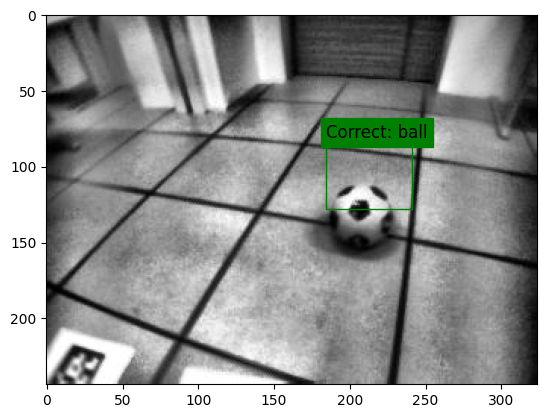

(244, 324, 1)
[154.7358   65.44713 193.87694 112.03531]
cone


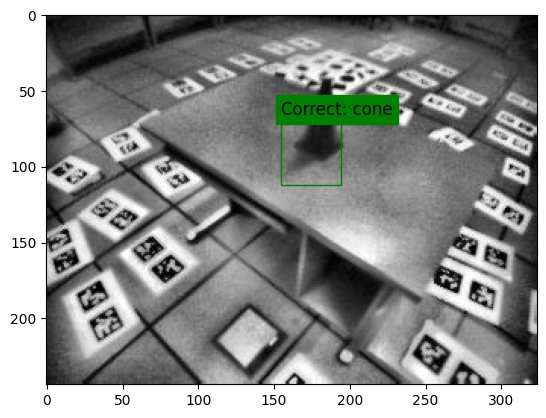

(244, 324, 1)
[134.1312   54.78061 161.08113 100.90858]
cone


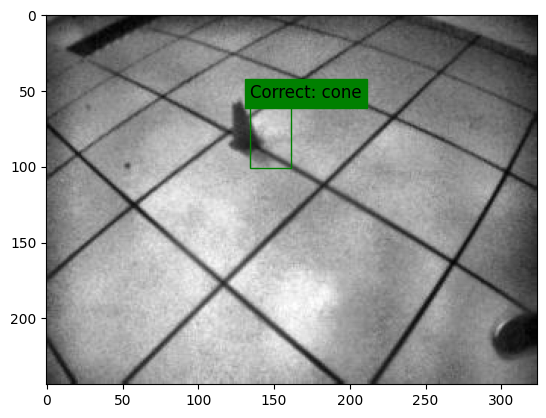

(244, 324, 1)
[127.75124   51.477856 150.92632   97.463326]
cone


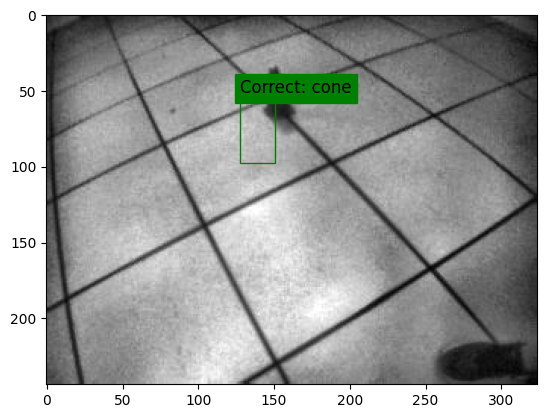

(244, 324, 1)
[31.60023    1.7026782 -2.1148906 45.540592 ]
none


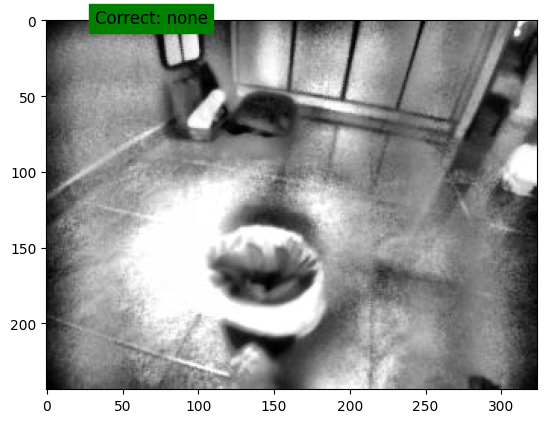

In [10]:
import matplotlib.pyplot as plt

# Loads the weights
# model = tf.keras.models.load_model('models/detector3_50.h5')
# model.summary(line_length = 100)
# model.load_weights('models/detector3_50.h5')

# Re-evaluate the model
# loss, acc = model.evaluate(test_images, test_labels, verbose=2)

# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# Function to visualize bounding boxes and class labels on images
def visualize_predictions(image, bbox, pred_label, label):
    plt.figure()
    print(label)
    plt.imshow(image, cmap='gray')
    xmin, ymin, xmax, ymax = bbox

    if (pred_label == 1 and label == "ball") or (pred_label == 2 and label == "cone"):
        plt.text(xmin, ymin, f'Correct: {label}' , fontsize=12, backgroundcolor='g')
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                    edgecolor='g', facecolor='none'))
    elif (pred_label == 0 and label == "none"):
        plt.text(xmin, ymin, f'Correct: {label}' , fontsize=12, backgroundcolor='g')
    else:
        plt.text(xmin, ymin, f'Wrong: Not {label}' , fontsize=12, backgroundcolor='r')
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                    edgecolor='r', facecolor='none'))
    plt.axis('on')
    plt.show()

# Make predictions on test dataset
predictions = model.predict(test_images)

# Parse predictions
predicted_labels = predictions[0]
predicted_bboxes = predictions[1]

# Visualize predictions for a few images
num_images_to_visualize = 5
x = np.random.randint(0, 20)
for i in range(x, x+num_images_to_visualize):
    image = test_images[i]  # Get the image
    label = test_labels[i]  # True label
    pred_label = np.argmax(predicted_labels[i])  # Predicted label
    bbox = predicted_bboxes[i]  # Predicted bounding box
    
    print(image.shape)
    # Rescale bounding box coordinates to original image dimensions
    height, width, _ = image.shape
    bbox[0] *= width
    bbox[1] *= height
    bbox[2] *= width
    bbox[3] *= height
    print(bbox)
    
    # Visualize predictions
    visualize_predictions(image.squeeze(), bbox, pred_label, label)



In [ ]:
import tensorflow as tf

# Adjust display options to show the full model summary
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, to_file='full_model_summary.png')


1/1 [==============================] - 0s 27ms/step
[0.338131   0.17236798 0.37642872 0.35916734]
[109.55445   42.057785 121.962906  87.63683 ]
cone


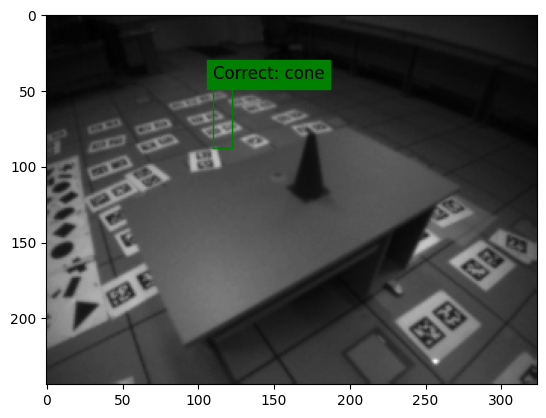

In [19]:
image = 'samples/5.png'  # Adjust this according to your test image directory
test_img = keras.preprocessing.image.load_img(image, target_size=(height, width), color_mode='grayscale')  # Convert to grayscale
test_img_arr = np.array(keras.preprocessing.image.img_to_array(test_img))
input = np.expand_dims(test_img_arr, axis=0)  # Add batch dimension if necessary
pred = model.predict(input)
height, width, _ = test_img_arr.shape
pred_label = np.argmax(pred[0])
bbox = pred[1][0]
print(bbox)
bbox[0] *= width
bbox[1] *= height
bbox[2] *= width
bbox[3] *= height
print(bbox)

visualize_predictions(test_img_arr.squeeze(), bbox, pred_label, "cone")


In [16]:
print('Exporting to TFLite')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(f"models/detection.tflite", "wb") as f:
    f.write(tflite_model)
print('Exported to TFLite')

Exporting to TFLite
INFO:tensorflow:Assets written to: /tmp/tmpchah9e6k/assets


INFO:tensorflow:Assets written to: /tmp/tmpchah9e6k/assets


Exported to TFLite


2024-02-11 09:47:08.316215: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-11 09:47:08.316241: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-11 09:47:08.316564: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpchah9e6k
2024-02-11 09:47:08.341986: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-11 09:47:08.342038: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpchah9e6k
2024-02-11 09:47:08.388618: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-02-11 09:47:08.418454: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-11 09:47:09.172446: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpchah9e6k
2024-02

In [20]:
print('Quantizing the model')
# Convert to quantized TensorFlow Lite
def representative_data_gen():
    for index, row in test_image_records.iterrows():
        (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

        test_image_fullpath = os.path.join(test_image_path, filename)
        test_img = keras.preprocessing.image.load_img(test_image_fullpath, target_size=(height, width), color_mode='grayscale')  # Convert to grayscale
        test_img_arr = keras.preprocessing.image.img_to_array(test_img)
        test_img_arr = np.expand_dims(test_img_arr, axis=0)  # Add an extra dimension for batch

        yield [test_img_arr.astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open(
    f"models/detection_q.tflite", "wb"
) as f:
    f.write(tflite_model)

Quantizing the model
INFO:tensorflow:Assets written to: /tmp/tmplmkjd1t1/assets


INFO:tensorflow:Assets written to: /tmp/tmplmkjd1t1/assets
/home/cweekiat/anaconda3/envs/cf/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-02-11 09:49:39.918396: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-11 09:49:39.918422: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-11 09:49:39.918600: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmplmkjd1t1
2024-02-11 09:49:39.945639: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-11 09:49:39.945670: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmplmkjd1t1
2024-02-11 09:49:40.032807: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-11

(1, 244, 324, 1)
Detected Class:  2
Detected Box  [78 35 69 95]
-


/tmp/ipykernel_4057/2845872899.py:28: RuntimeWarning: overflow encountered in ubyte_scalars
  plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,


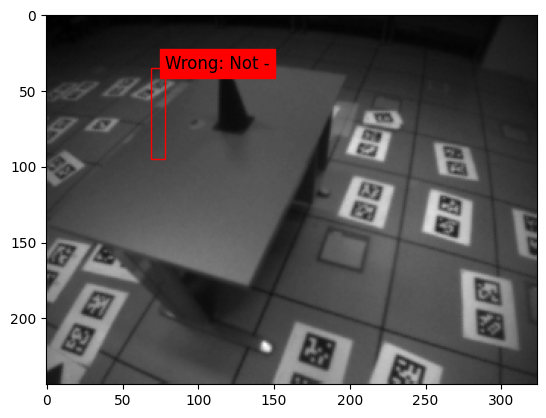

In [33]:
from tensorflow.python.ops.numpy_ops import np_config
# Set precision for TensorFlow operations to avoid NumPy warning
np_config.enable_numpy_behavior()

# Load the TFLite model
model_path = 'models/detection_q.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get the input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

image = 'samples/8.png'  # Adjust this according to your test image directory
test_img = keras.preprocessing.image.load_img(image, target_size=(height, width), color_mode='grayscale')  # Convert to grayscale
test_img_arr = np.array(keras.preprocessing.image.img_to_array(test_img))
input_image = np.expand_dims(test_img_arr.astype(np.uint8), axis=0)  # Add batch dimension if necessary
print(input_image.shape)
interpreter.set_tensor(input_details[0]['index'], input_image)
interpreter.invoke()

# Get the output tensors
output_boxes = interpreter.get_tensor(output_details[1]['index'])
output_classes = interpreter.get_tensor(output_details[0]['index'])
pred_label = np.argmax(output_classes[0])
bbox = output_boxes[0]
print("Detected Class: ", pred_label)
print("Detected Box ", bbox)

visualize_predictions(input_image.squeeze(), bbox, pred_label, "-")
